# library import:

In [2]:
import nltk
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
import urllib
from nltk.corpus import PlaintextCorpusReader
import pandas as pd
import urllib.request
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.metrics import silhouette_samples,silhouette_score
from array import *
from nltk.probability import FreqDist
import squarify
from itertools import chain
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random
import pickle
from yellowbrick.cluster import KElbowVisualizer

# data import:
## Loading the CSV where all URLs are stored
### CSV file containing all URLs is created separately. URLs are recorded from [PIB](https://pib.gov.in/indexd.aspx) and selected manually which are regarding Covid-19 press release in between March 2020 to July 2021.
#### *if more exhaustive data source for government policy can be applied, we’ll get better results of clustering. I found only PIB for this types of policy.

In [3]:
pib_corpus = pd.read_csv('E:/NLP_PROJECT/PIB_DATA.csv',encoding='unicode_escape')
pib_corpus['Content'] = "Will be filled"
pib_corpus.head(2)

,Title,Ministry,Date,URL,Content
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,Will be filled
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,Will be filled


# reading content from URL:
## extraction of web content by bs4
### In the following data frame "Content" named column contains the each of those reports in a unclean format extracted from recorded URLs.

In [4]:
for i in range(0,len(pib_corpus),1):
    webUrl  = urllib.request.urlopen(pib_corpus.iloc[i,3])
    data = webUrl.read()
    raw = BeautifulSoup(data,"html.parser").get_text()
    pib_corpus.loc[i,"Content"] = raw
pib_corpus.head(2)

,Title,Ministry,Date,URL,Content
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...


# removing \n, \r:
## here \n and \r which are occuring frequently in the report are replaced by blank space and stored in the "content_clean" column.

In [6]:
def remove_unnes(text):
    text_unnes = text.replace('\n', ' ')
    text_unnes = text_unnes.replace('\r', ' ')
    return text_unnes

pib_corpus['content_clean'] = pib_corpus['Content'].apply(lambda x: remove_unnes(x))

pib_corpus.head(2)

,Title,Ministry,Date,URL,Content,content_clean
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...


# removing punctuation :
## here all punctuations are removed and list of the punctuations are used from NLTK library, updated in the same column.

In [7]:
def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

pib_corpus['content_clean'] = pib_corpus['content_clean'].apply(lambda x: remove_punct(x))

pib_corpus.head(2)

,Title,Ministry,Date,URL,Content,content_clean
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...


# content tokenization:
## all content is tokenized and formatted in lower case for further analysis, stored in "content_tokenized"

In [8]:
pib_corpus['content_tokenized'] = pib_corpus['content_clean'].apply(lambda x: nltk.word_tokenize(x.lower()))
pib_corpus.head(2)

,Title,Ministry,Date,URL,Content,content_clean,content_tokenized
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, 1..."
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, p..."


# removing stopwards:
## stopwords list are used from NLTK library and all stopwords are removed from tokenized content.

In [10]:
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stopwords]
    return text

pib_corpus['content_nostop'] = pib_corpus['content_tokenized'].apply(lambda x: remove_stopwords(x))

pib_corpus.head(2)

,Title,Ministry,Date,URL,Content,content_clean,content_tokenized,content_nostop
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, 1...","[ministry, health, family, welfare, 1, crore, ..."
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, p...","[ministry, health, family, welfare, pradhan, m..."


# lemmatization of content:
## next NLTK lemmatizer is used to lemmatize the content and stored in the "content_lemmatized"

In [11]:
wn = nltk.WordNetLemmatizer()
def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

pib_corpus['content_lemmatized'] = pib_corpus['content_nostop'].apply(lambda x: lemmatizing(x))

pib_corpus.head(2)

,Title,Ministry,Date,URL,Content,content_clean,content_tokenized,content_nostop,content_lemmatized
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, 1...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, 1, crore, ..."
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, p...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m..."


# content without number:
## as many separate numbers are in the lemmatized content which are not significant individually, here these numbers are replaced by blank space and stored in the "w/o_num" column

In [12]:
pib_corpus['w/o_num'] = "Will be filled"
wolist = []
for i in range(0,len(pib_corpus),1) :
    
    for j in range(0,len(pib_corpus['content_lemmatized'][i]),1) :
        text = pib_corpus['content_lemmatized'][i][j]
        run = re.sub('[0-9]+', '', text)
        wolist.append(run)
    
    pib_corpus.loc[i,"w/o_num"] = wolist
    wolist=[]
pib_corpus.head(2)

,Title,Ministry,Date,URL,Content,content_clean,content_tokenized,content_nostop,content_lemmatized,w/o_num
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, 1...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, , crore, t..."
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, p...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m..."


# removing some extra words:
## some extra words which are no significant for analysis are found manually and removed accordingly

In [14]:
extra_words = ["","\"","\'","ü","अन्न","अभियान","आत्मनिर्भर","कुष्ठावस्थाविकलांगभरणपोषणअनुदान",
               "भारत","वृद्धावस्थाकिसानपेंशनयोजना","–","–i","–rch","—","‘","’","“","”","•","₹"]
def remove_extra(some_text):
    text = [word for word in some_text if word not in extra_words]
    return text

pib_corpus['w/o_num'] = pib_corpus['w/o_num'].apply(lambda x: remove_extra(x))

pib_corpus.head(2)

,Title,Ministry,Date,URL,Content,content_clean,content_tokenized,content_nostop,content_lemmatized,w/o_num
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, 1...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, crore, tre..."
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, p...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m..."


# removing stopwards:

In [15]:
pib_corpus['w/o_num'] = pib_corpus['w/o_num'].apply(lambda x: remove_stopwords(x))
pib_corpus.head(2)

,Title,Ministry,Date,URL,Content,content_clean,content_tokenized,content_nostop,content_lemmatized,w/o_num
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, 1...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, crore, tre..."
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, p...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m..."


In [18]:
for j in range(0,len(pib_corpus),1) :
    
    for i in range(0,len(pib_corpus['w/o_num'][j])) :
        
        if len(pib_corpus['w/o_num'][j][i]) < 3:
            
            print(pib_corpus['w/o_num'][j][i])

dr
pm
dr
mo
dr
dr
le
r
u
r
u
dr
dr
dr
sh
id
dr
pm
dr
mo
dr
dr
le
r
u
r
u
dr
dr
dr
sh
id
pm
r
mv
id
pm
r
mv
id
r
pm
rs
rs
th
mo
r
ut
mv
id
r
pm
rs
rs
th
mo
r
ut
mv
id
n
pm
n
st
n
ut
ut
n
n
n
id
n
pm
n
st
n
ut
ut
n
n
n
id
r
cr
ii
pm
r
cr
th
r
cr
hr
mv
id
r
cr
ii
pm
r
cr
th
r
cr
hr
mv
id
pm
ie
th
ie
r
mv
id
pm
ie
th
ie
r
mv
id
dr
pm
dr
n
sh
ut
th
ii
iv
v
vi
ix
x
xi
th
ut
rd
th
th
nd
th
nd
ii
iv
v
vi
ii
th
fw
th
rd
n
th
n
av
sm
sm
rd
g
r
u
mv
id
dr
pm
dr
n
sh
ut
th
ii
iv
v
vi
ix
x
xi
th
ut
rd
th
th
nd
th
nd
ii
iv
v
vi
ii
th
fw
th
rd
n
th
n
av
sm
sm
rd
g
r
u
mv
id
pm
ut
ut
fy
r
ut
r
sl
b
c
e
ut
wo
f
sh
mv
id
pm
ut
ut
fy
r
ut
r
sl
b
c
e
ut
wo
f
sh
mv
id
pm
sl
n
r
th
r
ut
n
sh
id
pm
sl
n
r
th
r
ut
n
sh
id
pm
ab
r
r
r
r
ii
ab
sl
ii
sr
r
r
r
ab
ab
r
r
r
sh
id
pm
ab
r
r
r
r
ii
ab
sl
ii
sr
r
r
r
ab
ab
r
r
r
sh
id
pm
n
r
n
rs
r
ut
n
sh
id
pm
n
r
n
rs
r
ut
n
sh
id
pm
pm
sh
id
pm
pm
sh
id
pm
fy
r
r
r
r
th
ut
n
n
n
n
n
sh
id
pm
fy
r
r
r
r
th
ut
n
n
n
n
n
sh
id
ce
pm
ce
b
ce
gb
ce
ce
id
ce
pm
ce
b
ce


# removing word with length < 3:
## those words which were not removed by stopwords and length of those words are also less than 3 are removed and stored the in the column "w/o_num_updated"

In [20]:
pib_corpus['w/o_num_updated'] = "Will be filled"
sh_list = []

for j in range(0,len(pib_corpus),1) :
    
    for i in range(0,len(pib_corpus['w/o_num'][j])) :
        
        if len(pib_corpus['w/o_num'][j][i]) > 2:
            
            main = pib_corpus['w/o_num'][j][i]
            sh_list.append(main)
    
    pib_corpus.loc[j,"w/o_num_updated"] = sh_list
    sh_list=[]

pib_corpus.head(2)

,Title,Ministry,Date,URL,Content,content_clean,content_tokenized,content_nostop,content_lemmatized,w/o_num,w/o_num_updated
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, 1...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, crore, tre...","[ministry, health, family, welfare, crore, tre..."
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, p...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m..."


# blank analyzer initialization for vectorization:

In [21]:
def clean_text(text):
    return text

# seed setting:

In [22]:
random.seed(10)

# process 1 :
## by taking w/o_num_updated (which consists of all words without number and lengths are also greater than 2) column

## TF-DIF vectorization:
### here TF-IDF vectorization is used to convert those words into their numeric counter parts. TF-IDF automatically assign weights for each words considering its importance throught out all observations. 
### Weight for i-th word in j-th document: $$ w_{i,j} = tf_{i,j} * \log \left(\frac{N}{df_i}\right) $$
### where $tf_{i,j}$ = number of occurances of i in j, $df_i$ = number of documents containing i, $N$ = total number of documents

In [29]:
tfidf_vect_wo_number = TfidfVectorizer(analyzer=clean_text)
X_tfidf_wo_number = tfidf_vect_wo_number.fit_transform(pib_corpus['w/o_num_updated'])
print(X_tfidf_wo_number.shape)
X_tfidf_df_wo_number = pd.DataFrame(X_tfidf_wo_number.toarray())
X_tfidf_df_wo_number.columns = tfidf_vect_wo_number.get_feature_names()
print(X_tfidf_df_wo_number.head(2))

(56, 3462)
   aadhaar  aadhaarpan  aatma  aatmanirbhar    aayog  abhiyaan  abhiyan  \
0      0.0         0.0    0.0           0.0  0.03515       0.0      0.0   
1      0.0         0.0    0.0           0.0  0.00000       0.0      0.0   

   abhwcs  abiding      able  ...  yet  yogi    yojana  yojanabr  yojna  yoy  \
0     0.0      0.0  0.027599  ...  0.0   0.0  0.066248       0.0    0.0  0.0   
1     0.0      0.0  0.000000  ...  0.0   0.0  0.000000       0.0    0.0  0.0   

   zhu  zhusaid  zone  zoonotic  
0  0.0      0.0   0.0       0.0  
1  0.0      0.0   0.0       0.0  

[2 rows x 3462 columns]


### for this clustering and elbow method refer to [this](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html)

## kmeans for this process:
### using distortion score

### distortion score = the sum of square distances from each point to its assigned center. It is the sum of sum of square errors (SSE). Formula of this is : $$ WCSS = \sum_{i=1}^{k} \sum_{x \in S_i} ||x-\mu_i||^2$$ for $S_1, S_2, \dots, S_k $ clusters with means $\mu_1,\mu_2,\dots,\mu_k$

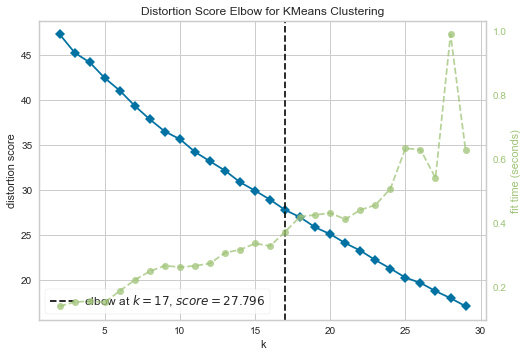

In [39]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30))
visualizer.fit(X_tfidf_df_wo_number)
visualizer.show()

## kmeans for this process:
### using silhouette score method

### The [Silhouette Coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is $ \frac{(b - a)}{\max(a, b)}$. b is the distance between a sample and the nearest cluster that the sample is not a part of. 

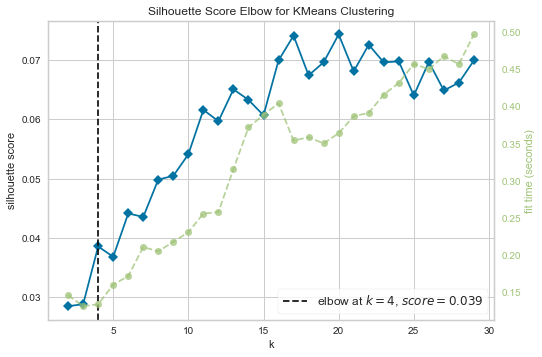

In [42]:
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(X_tfidf_df_wo_number)
visualizer.show()

### In this part different silhouette scores are calculated for different principal components and different number of clusters of the "X_tfidf_df_wo_number" dataframe.

## using PCA:

In [43]:
si_avg_pca=[]
si_avg_pca_list=[]
for i in range(2,21,1) :
    x_standard = StandardScaler().fit_transform(X_tfidf_df_wo_number)
    pca = PCA(n_components=i)
    principalComponents = pca.fit_transform(x_standard)
    principalDf = pd.DataFrame(data = principalComponents)
    
    for k in range(2,11):
        kmeans_pca=KMeans(n_clusters=k, init="k-means++")
        kmeans_pca.fit(principalDf)
        cluster_labels_pca = kmeans_pca.fit_predict(principalDf)
        silhouette_avg_pca = silhouette_score(principalDf, cluster_labels_pca)
        print("For n_clusters =", k,"and PCA:",i, "The average silhouette_score is :", silhouette_avg_pca)
        si_avg_pca.append(silhouette_avg_pca)
    
    si_avg_pca_list.append(si_avg_pca)
    si_avg_pca=[]

For n_clusters = 2 and PCA: 2 The average silhouette_score is : 0.9300986444322644
For n_clusters = 3 and PCA: 2 The average silhouette_score is : 0.8938774179736872
For n_clusters = 4 and PCA: 2 The average silhouette_score is : 0.8032361516093659
For n_clusters = 5 and PCA: 2 The average silhouette_score is : 0.6099544021912389
For n_clusters = 6 and PCA: 2 The average silhouette_score is : 0.4068173402640464
For n_clusters = 7 and PCA: 2 The average silhouette_score is : 0.3931340084578872
For n_clusters = 8 and PCA: 2 The average silhouette_score is : 0.3778937498837453
For n_clusters = 9 and PCA: 2 The average silhouette_score is : 0.41837693559123196
For n_clusters = 10 and PCA: 2 The average silhouette_score is : 0.3831583477683385
For n_clusters = 2 and PCA: 3 The average silhouette_score is : 0.9058353335439406
For n_clusters = 3 and PCA: 3 The average silhouette_score is : 0.8668234277117483
For n_clusters = 4 and PCA: 3 The average silhouette_score is : 0.8564544485866181
Fo

In [44]:
pca1_row_name=[]
for i in range(2,21,1):
    txt = "pca "+ str(i)
    pca1_row_name.append(txt)
pca1_col_name=[]
for i in range(2,11,1):
    txt = "n_cluster "+ str(i)
    pca1_col_name.append(txt)

In [45]:
pca_table_1 = pd.DataFrame(si_avg_pca_list,columns = pca1_col_name,index=pca1_row_name)
pca_table_1

,n_cluster 2,n_cluster 3,n_cluster 4,n_cluster 5,n_cluster 6,n_cluster 7,n_cluster 8,n_cluster 9,n_cluster 10
pca 2,0.930099,0.893877,0.803236,0.609954,0.406817,0.393134,0.377894,0.418377,0.383158
pca 3,0.905835,0.866823,0.856454,0.745311,0.748965,0.657905,0.310517,0.287515,0.329282
pca 4,0.874306,0.814683,0.808592,0.757185,0.685217,0.651170,0.644077,0.636733,0.413013
pca 5,0.857647,0.788567,0.787186,0.737653,0.750451,0.662363,0.669429,0.615094,0.604343
pca 6,0.842644,0.765550,0.763836,0.748406,0.750999,0.730208,0.646726,0.654967,0.603952
pca 7,0.830403,0.748225,0.745666,0.742679,0.747451,0.743596,0.748615,0.665689,0.617342
pca 8,0.817065,0.727131,0.725644,0.715793,0.724481,0.732330,0.737754,0.739677,0.593823
pca 9,0.805264,0.709247,0.707586,0.700132,0.704375,0.712722,0.720469,0.726505,0.733469
pca 10,0.788116,0.684883,0.679537,0.668828,0.672911,0.679819,0.688248,0.692704,0.697299
pca 11,0.772657,0.661478,0.653415,0.641368,0.645971,0.651364,0.658763,0.661019,0.666330


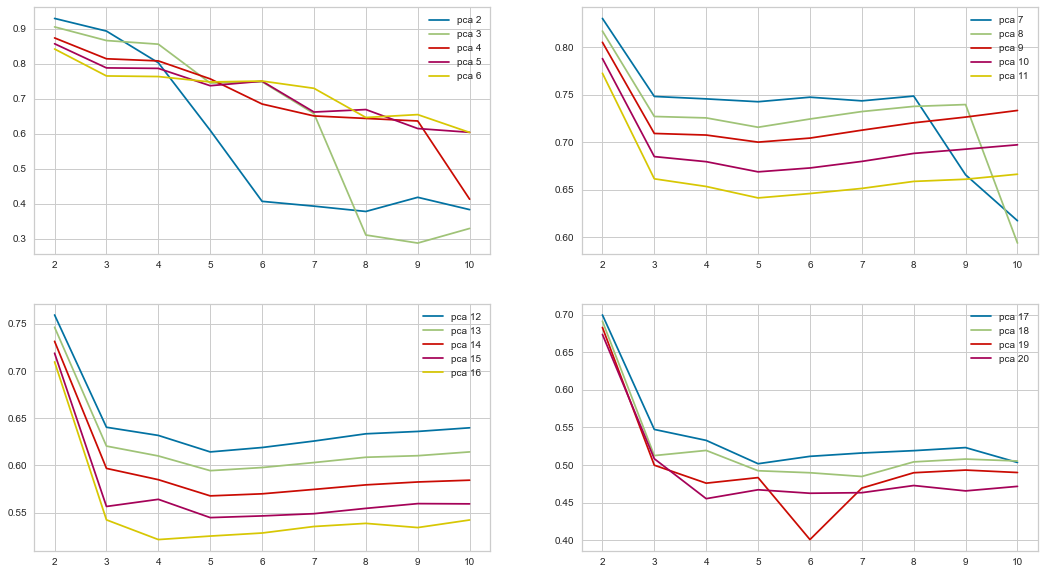

In [46]:
figure, axis = plt.subplots(2,2,figsize=(18,10))

for i in range(0,5,1):
    axis[0,0].plot(range(2, 11), pca_table_1.iloc[i])
axis[0,0].legend(pca1_row_name[0:5])

for i in range(5,10,1):
    axis[0,1].plot(range(2, 11), pca_table_1.iloc[i])
axis[0,1].legend(pca1_row_name[5:10])

for i in range(10,15,1):
    axis[1,0].plot(range(2, 11), pca_table_1.iloc[i])
axis[1,0].legend(pca1_row_name[10:15])

for i in range(15,19,1):
    axis[1,1].plot(range(2, 11), pca_table_1.iloc[i])
axis[1,1].legend(pca1_row_name[15:19])

plt.show()

### In the following section all same things are done but for different columns. A columns "most_common" is created which consists of most commonly occuring 35 words for each observations

### Other methods will be repeated and same as before

# process 2 :
## by taking most frequent 35 words

## most_common column creation:

In [47]:
pib_corpus['most_common'] = "Will be filled"
com_list=[]
for i in range(0,len(pib_corpus),1) :
    
    for j in range(0,35,1) :
        fdist = FreqDist(pib_corpus['w/o_num_updated'][i])
        a = [fdist.most_common(35)]
        arun = a[0][j][0]
        com_list.append(arun)
    
    pib_corpus.loc[i,"most_common"] = com_list
    com_list=[]
pib_corpus.head(2)

,Title,Ministry,Date,URL,Content,content_clean,content_tokenized,content_nostop,content_lemmatized,w/o_num,w/o_num_updated,most_common
0,1 Crore Treatments Provided Under Ayushman Bha...,Ministry of Health and Family Welfare,21 MAY 2020 6:16PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, 1...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, 1, crore, ...","[ministry, health, family, welfare, crore, tre...","[ministry, health, family, welfare, crore, tre...","[health, crore, treatment, ayushman, bharat, h..."
1,Pradhan Mantri Garib Kalyan Package: Insurance...,Ministry of Health and Family Welfare,29 MAR 2020 5:14PM,https://pib.gov.in/PressReleasePage.aspx?PRID=...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,...,"[ministry, of, health, and, family, welfare, p...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m...","[ministry, health, family, welfare, pradhan, m...","[health, insurance, covid, ministry, pradhan, ..."


## TF-DIF vectorization:

In [48]:
tfidf_vect_common = TfidfVectorizer(analyzer=clean_text)
X_tfidf_common = tfidf_vect_common.fit_transform(pib_corpus['most_common'])
print(X_tfidf_common.shape)
X_tfidf_df_common = pd.DataFrame(X_tfidf_common.toarray())
X_tfidf_df_common.columns = tfidf_vect_common.get_feature_names()
print(X_tfidf_df_common.head(2))

(56, 759)
   aatma  aatmanirbhar  abhiyaan   abpmjay  accelerating   account  achieve  \
0    0.0           0.0       0.0  0.195071           0.0  0.000000      0.0   
1    0.0           0.0       0.0  0.000000           0.0  0.152243      0.0   

   achieved  across  act  ...  wise  within  woman    worker  working  world  \
0       0.0     0.0  0.0  ...   0.0     0.0    0.0  0.000000      0.0    0.0   
1       0.0     0.0  0.0  ...   0.0     0.0    0.0  0.146948      0.0    0.0   

   worth  would  year    yojana  
0    0.0    0.0   0.0  0.160791  
1    0.0    0.0   0.0  0.000000  

[2 rows x 759 columns]


## kmeans for this process:
### using distortion score

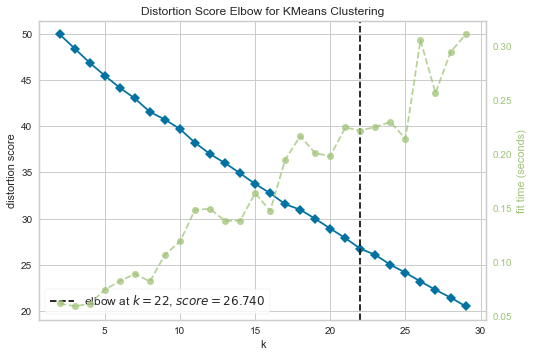

In [51]:
visualizer = KElbowVisualizer(model, k=(2,30))
visualizer.fit(X_tfidf_df_common)
visualizer.show()

## kmeans for this process:
### using silhouette score method

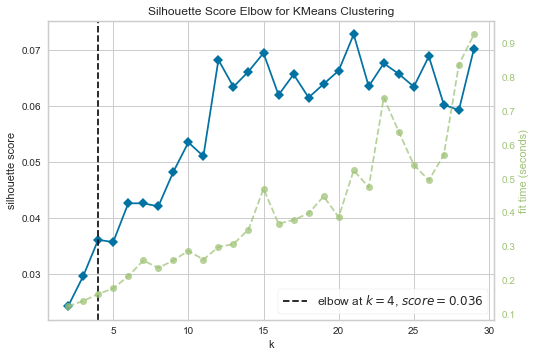

In [52]:
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(X_tfidf_df_wo_number)
visualizer.show()

## using PCA:

In [53]:
si_avg_pca=[]
si_avg_pca_list=[]
for i in range(2,21,1) :
    x_standard = StandardScaler().fit_transform(X_tfidf_df_common)
    pca = PCA(n_components=i)
    principalComponents = pca.fit_transform(x_standard)
    principalDf = pd.DataFrame(data = principalComponents)
    
    for k in range(2,11):
        kmeans_pca=KMeans(n_clusters=k, init="k-means++")
        kmeans_pca.fit(principalDf)
        cluster_labels_pca = kmeans_pca.fit_predict(principalDf)
        silhouette_avg_pca = silhouette_score(principalDf, cluster_labels_pca)
        print("For n_clusters =", k,"and PCA:",i, "The average silhouette_score is :", silhouette_avg_pca)
        si_avg_pca.append(silhouette_avg_pca)
    
    si_avg_pca_list.append(si_avg_pca)
    si_avg_pca=[]

For n_clusters = 2 and PCA: 2 The average silhouette_score is : 0.5777284732615523
For n_clusters = 3 and PCA: 2 The average silhouette_score is : 0.4801204810853474
For n_clusters = 4 and PCA: 2 The average silhouette_score is : 0.5024521921108195
For n_clusters = 5 and PCA: 2 The average silhouette_score is : 0.4805539750009816
For n_clusters = 6 and PCA: 2 The average silhouette_score is : 0.4603307229429155
For n_clusters = 7 and PCA: 2 The average silhouette_score is : 0.4410374007540353
For n_clusters = 8 and PCA: 2 The average silhouette_score is : 0.41453284719568334
For n_clusters = 9 and PCA: 2 The average silhouette_score is : 0.3993580946422764
For n_clusters = 10 and PCA: 2 The average silhouette_score is : 0.38715365510022887
For n_clusters = 2 and PCA: 3 The average silhouette_score is : 0.4472581330184608
For n_clusters = 3 and PCA: 3 The average silhouette_score is : 0.3635126565600803
For n_clusters = 4 and PCA: 3 The average silhouette_score is : 0.4192418931160194
F

In [54]:
pca_table_2 = pd.DataFrame(si_avg_pca_list,columns = pca1_col_name,index=pca1_row_name)
pca_table_2

,n_cluster 2,n_cluster 3,n_cluster 4,n_cluster 5,n_cluster 6,n_cluster 7,n_cluster 8,n_cluster 9,n_cluster 10
pca 2,0.577728,0.480120,0.502452,0.480554,0.460331,0.441037,0.414533,0.399358,0.387154
pca 3,0.447258,0.363513,0.419242,0.399749,0.366396,0.339297,0.358287,0.365150,0.369588
pca 4,0.371231,0.283730,0.324890,0.324217,0.323215,0.347274,0.326933,0.341183,0.339219
pca 5,0.386290,0.240521,0.249780,0.281782,0.300023,0.304838,0.324422,0.300779,0.291306
pca 6,0.339018,0.206491,0.236102,0.232478,0.259034,0.266117,0.255441,0.235044,0.246749
pca 7,0.258084,0.171442,0.174334,0.191672,0.209799,0.196155,0.206484,0.225644,0.208105
pca 8,0.273281,0.241637,0.168672,0.175682,0.188993,0.190828,0.215845,0.193367,0.214199
pca 9,0.295447,0.169255,0.165148,0.192401,0.169467,0.225279,0.226180,0.195468,0.233837
pca 10,0.250337,0.307877,0.172555,0.172979,0.182382,0.163918,0.212729,0.197740,0.176240
pca 11,0.243911,0.107595,0.268048,0.125816,0.133845,0.130980,0.148615,0.184407,0.172591


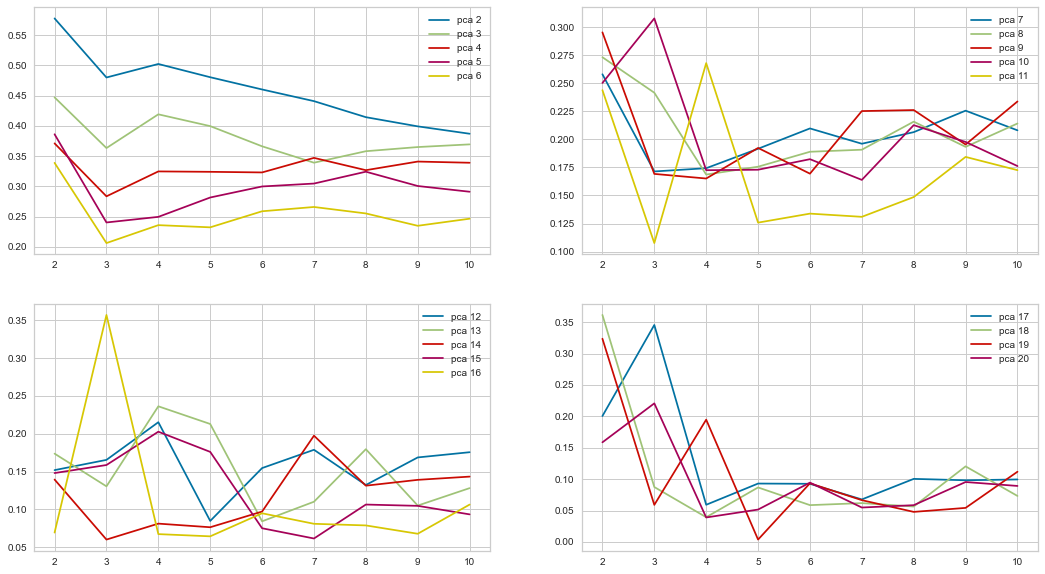

In [55]:
figure, axis = plt.subplots(2,2,figsize=(18,10))

for i in range(0,5,1):
    axis[0,0].plot(range(2, 11), pca_table_2.iloc[i])
axis[0,0].legend(pca1_row_name[0:5])

for i in range(5,10,1):
    axis[0,1].plot(range(2, 11), pca_table_2.iloc[i])
axis[0,1].legend(pca1_row_name[5:10])

for i in range(10,15,1):
    axis[1,0].plot(range(2, 11), pca_table_2.iloc[i])
axis[1,0].legend(pca1_row_name[10:15])

for i in range(15,19,1):
    axis[1,1].plot(range(2, 11), pca_table_2.iloc[i])
axis[1,1].legend(pca1_row_name[15:19])

plt.show()

# References:
- https://scikit-learn.org/stable/modules/clustering.html#k-means
- https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
- https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad